# Proyecto Segundo Parcial
## Clasificacion supervisada del riesgo de inundacion por parroquia (Provincia del Guayas, Ecuador)

**Carrera/Asignatura:** Ciencia de Datos e Inteligencia Artificial  
**Tipo de problema:** Clasificacion supervisada (no regresion)  
**Unidad territorial:** Parroquia

Este cuaderno documenta de forma tecnica y trazable el flujo completo del proyecto:
1. Importacion de datos con referencia de fuentes oficiales.
2. Limpieza y control de calidad del dataset.
3. Construccion de la variable objetivo de riesgo (sin usar etiquetas predefinidas).
4. Entrenamiento de modelos requeridos (RL, DT, ensamble).
5. Optimizacion con GridSearchCV.
6. Evaluacion comparativa con precision, recall, F1 y ROC-AUC.
7. Integracion de resultados con el GeoJSON usado por la aplicacion Flask.


## 1) Alcance, restricciones y criterio tecnico

Este proyecto se apega a las restricciones solicitadas:
- Se trabaja con datos de entidades oficiales del Ecuador y una base historica consolidada del proyecto.
- No se usan datasets con etiqueta de riesgo final ya predefinida.
- La etiqueta objetivo se construye con criterio tecnico reproducible.
- Se implementan al menos: Regresion Logistica, Arbol de Decision y Ensamble.
- Se aplica GridSearchCV para optimizar al menos un modelo.
- La metrica prioritaria para gestion de riesgo es **recall** (minimizar falsos negativos en zonas con riesgo alto).


In [4]:
from __future__ import annotations

import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

try:
    import seaborn as sns
    HAS_SNS = True
except Exception:
    HAS_SNS = False

try:
    from IPython.display import display
except Exception:
    def display(x):
        print(x)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

if HAS_SNS:
    sns.set_theme(style='whitegrid', palette='Set2')


In [5]:
ROOT = Path.cwd().resolve()
if ROOT.name != 'entregables':
    ROOT = ROOT / 'entregables'

DATA_RAW = ROOT / 'data' / 'raw'
OUTPUTS = ROOT / 'outputs'
APP_DATA = ROOT / 'app' / 'data'

historical_path = DATA_RAW / 'dataset_proyecto.csv'
full_dataset_path = OUTPUTS / 'dataset_guayas_oficial_completo.csv'
predictions_path = OUTPUTS / 'predicciones_parroquias.csv'
metrics_path = OUTPUTS / 'resumen_metricas_modelos.csv'
source_registry_path = OUTPUTS / 'fuentes_y_metodologia_oficial.json'
geojson_path = APP_DATA / 'parroquias_riesgo.geojson'

for p in [historical_path, full_dataset_path, predictions_path, metrics_path, source_registry_path, geojson_path]:
    print(f'{p.name}: {p.exists()}')


dataset_proyecto.csv: True
dataset_guayas_oficial_completo.csv: True
predicciones_parroquias.csv: True
resumen_metricas_modelos.csv: True
fuentes_y_metodologia_oficial.json: True
parroquias_riesgo.geojson: True


## 2) Importacion y referencia de fuentes oficiales

Las fuentes usadas por el pipeline quedan registradas en `outputs/fuentes_y_metodologia_oficial.json`.

### Fuentes
- INEC DPA Parroquias (ArcGIS REST): geometria y codigos oficiales de parroquia.
- INEC Censo 2022 MANLOC: variables socio-territoriales (poblacion, hogares, viviendas, estructura demografica).
- IGM DTM WMS: variables topograficas (altitud y derivadas de pendiente/rango altitudinal).
- Base historica consolidada INAMHI + SNGRE (`data/raw/dataset_proyecto.csv`): series climaticas y eventos de inundacion historicos.


In [6]:
with source_registry_path.open('r', encoding='utf-8') as f:
    source_registry = json.load(f)

sources_df = pd.DataFrame([
    {'fuente': k, 'referencia': v}
    for k, v in source_registry.get('fuentes_oficiales', {}).items()
])

variables_df = pd.DataFrame([
    {'grupo': grupo, 'variables': ', '.join(vars_list)}
    for grupo, vars_list in source_registry.get('variables_integradas', {}).items()
])

print('Fuentes oficiales:')
display(sources_df)
print('Variables integradas por grupo:')
display(variables_df)


Fuentes oficiales:


,fuente,referencia
0,INEC_DPA_Parroquias_ArcGIS,https://services7.arcgis.com/iFGeGXTAJXnjq0YN/...
1,INEC_Censo2022_MANLOC_CSV,https://www.ecuadorencifras.gob.ec/documentos/...
2,IGM_DTM_WMS,https://www.geoportaligm.gob.ec/dtm/ows
3,INAMHI_SNGRE_base_historica_consolidada,/Users/susanito/Downloads/entregables/data/raw...


Variables integradas por grupo:


,grupo,variables
0,climaticas,"precipitacion_mensual_prom_mm, precipitacion_m..."
1,topograficas,"altitud_igm_m, pendiente_igm, rango_altitud_igm_m"
2,socio_territoriales,"poblacion_2022, densidad_poblacional_2022, pct..."


## 3) Carga de datos

Se cargan dos datasets principales:
- `dataset_proyecto.csv`: base historica mensual por parroquia para construir etiquetas y variables climaticas.
- `dataset_guayas_oficial_completo.csv`: dataset final integrado por parroquia (clima + topografia + socio-territorial).


In [7]:
df_hist_raw = pd.read_csv(historical_path)
df_full = pd.read_csv(full_dataset_path)

print('Historico:', df_hist_raw.shape)
print('Integrado final:', df_full.shape)

print('Columnas historico:')
print(df_hist_raw.columns.tolist())


Historico: (5760, 19)
Integrado final: (54, 38)
Columnas historico:
['Código', 'Nombre de provincia', 'Nombre de canton', 'Nombre de parroquia', 'Población', 'Superficie de la parroquia (km2)', 'Densidad Poblacional', 'Latitud', 'Longitud', 'Precipitacion_Anual', 'cod_canton', 'nombre_canton', 'anio', 'mes', 'precipitacion_mm', 'temp_media_c', 'humedad_relativa', 'inundacion', 'Cerca_Rio']


## 4) Limpieza del dataset historico (requisito del proyecto)

En esta seccion se documenta limpieza con pasos explicitos:
1. Normalizacion de nombres de columnas y codigos.
2. Correccion de tipos numericos.
3. Correccion de formato de fechas (`anio`, `mes` -> `fecha_periodo`).
4. Revision y manejo de duplicados.
5. Revision de valores faltantes.


In [8]:
# 4.1 Estandarizacion minima de nombres
rename_map = {
    'Codigo': 'codigo',
    'Código': 'codigo',
    'Nombre de provincia': 'provincia',
    'Nombre de canton': 'canton',
    'Nombre de parroquia': 'parroquia',
    'Población': 'poblacion',
    'Superficie de la parroquia (km2)': 'superficie_km2',
    'Densidad Poblacional': 'densidad_poblacional',
    'Latitud': 'latitud',
    'Longitud': 'longitud',
    'Precipitacion_Anual': 'precipitacion_anual',
    'Cerca_Rio': 'cerca_rio',
}

df_hist = df_hist_raw.rename(columns=rename_map).copy()

def normalize_code(value: object) -> str:
    digits = ''.join(ch for ch in str(value) if ch.isdigit())
    return digits.lstrip('0')

if 'codigo' in df_hist.columns:
    df_hist['codigo'] = df_hist['codigo'].map(normalize_code)

# 4.2 Tipos numericos
numeric_cols = [
    'poblacion', 'superficie_km2', 'densidad_poblacional', 'latitud', 'longitud',
    'precipitacion_anual', 'anio', 'mes', 'precipitacion_mm', 'temp_media_c',
    'humedad_relativa', 'inundacion', 'cerca_rio'
]
for col in numeric_cols:
    if col in df_hist.columns:
        df_hist[col] = pd.to_numeric(df_hist[col], errors='coerce')

# 4.3 Fecha de periodo
if {'anio', 'mes'}.issubset(df_hist.columns):
    df_hist['anio'] = df_hist['anio'].astype('Int64')
    df_hist['mes'] = df_hist['mes'].astype('Int64')
    valid_ym = df_hist['anio'].notna() & df_hist['mes'].between(1, 12)
    df_hist.loc[valid_ym, 'fecha_periodo'] = pd.to_datetime(
        dict(year=df_hist.loc[valid_ym, 'anio'].astype(int), month=df_hist.loc[valid_ym, 'mes'].astype(int), day=1),
        errors='coerce'
    )

# 4.4 Duplicados: se evalua por codigo-anio-mes
subset_dups = [c for c in ['codigo', 'anio', 'mes'] if c in df_hist.columns]
dups_count = int(df_hist.duplicated(subset=subset_dups).sum()) if subset_dups else 0

# 4.5 Faltantes
missing_report = df_hist.isna().sum().sort_values(ascending=False).head(15)

print('Filas historico (despues de limpieza):', len(df_hist))
print('Duplicados en llave codigo-anio-mes:', dups_count)
print('Top faltantes:')
display(missing_report.to_frame('nulos'))


Filas historico (despues de limpieza): 5760
Duplicados en llave codigo-anio-mes: 0
Top faltantes:


,nulos
codigo,0
provincia,0
canton,0
parroquia,0
poblacion,0
superficie_km2,0
densidad_poblacional,0
latitud,0
longitud,0
precipitacion_anual,0


In [9]:
if dups_count > 0:
    df_hist = df_hist.drop_duplicates(subset=subset_dups, keep='first').copy()
    print('Se eliminaron duplicados. Filas finales historico:', len(df_hist))
else:
    print('No se detectaron duplicados en codigo-anio-mes.')


No se detectaron duplicados en codigo-anio-mes.


## 5) Construccion y justificacion de la variable objetivo

No se usa una etiqueta de riesgo final predefinida. Se construye una etiqueta binaria a partir del historico de inundacion:

- `eventos_inundacion`: suma de eventos por parroquia.
- `total_periodos`: numero de periodos observados por parroquia.
- `tasa_inundacion_historica = eventos_inundacion / total_periodos`.
- Umbral de alto riesgo: percentil 66 de la tasa historica.
- Etiqueta final para entrenamiento: `target_alto_riesgo` (1 = alto riesgo, 0 = no alto).


In [10]:
if 'inundacion' not in df_hist.columns:
    raise ValueError("La columna 'inundacion' es obligatoria para construir la etiqueta objetivo.")

df_hist['inundacion'] = pd.to_numeric(df_hist['inundacion'], errors='coerce').fillna(0).astype(int)

labels_df = (
    df_hist.groupby('codigo', as_index=False)
    .agg(eventos_inundacion=('inundacion', 'sum'), total_periodos=('inundacion', 'count'))
)
labels_df['tasa_inundacion_historica'] = labels_df['eventos_inundacion'] / labels_df['total_periodos'].replace(0, np.nan)
labels_df['tasa_inundacion_historica'] = labels_df['tasa_inundacion_historica'].fillna(0)

threshold = float(labels_df['tasa_inundacion_historica'].quantile(0.66))
labels_df['target_alto_riesgo'] = (labels_df['tasa_inundacion_historica'] >= threshold).astype(int)

print(f'Umbral percentil 66: {threshold:.4f}')
print(labels_df['target_alto_riesgo'].value_counts().rename({0: 'No alto', 1: 'Alto'}))


Umbral percentil 66: 0.1250
target_alto_riesgo
No alto    24
Alto       16
Name: count, dtype: int64


## 6) Integracion de variables climaticas + topograficas + socio-territoriales

El dataset integrado `outputs/dataset_guayas_oficial_completo.csv` contiene variables de los tres grupos:

### Climaticas
- `precipitacion_mensual_prom_mm`
- `precipitacion_mensual_p95_mm`
- `precipitacion_anual_prom_mm`
- `temperatura_media_prom_c`
- `humedad_relativa_prom`
- `cerca_rio_prom`

### Topograficas
- `altitud_igm_m`
- `pendiente_igm` (**derivada**)
- `rango_altitud_igm_m` (**derivada**)

### Socio-territoriales
- `poblacion_2022`, `hogares_2022`, `viviendas_2022`
- `densidad_poblacional_2022`
- `pct_urbana_2022`
- `indice_compacidad` (**derivada**), entre otras.


In [11]:
required_features = [
    'precipitacion_mensual_prom_mm', 'precipitacion_mensual_p95_mm', 'precipitacion_anual_prom_mm',
    'temperatura_media_prom_c', 'humedad_relativa_prom', 'cerca_rio_prom',
    'altitud_igm_m', 'pendiente_igm', 'rango_altitud_igm_m',
    'poblacion_2022', 'hogares_2022', 'viviendas_2022', 'densidad_poblacional_2022',
    'pct_urbana_2022', 'indice_compacidad'
]

missing_required = [c for c in required_features if c not in df_full.columns]
print('Variables requeridas faltantes:', missing_required)

na_report = df_full[required_features].isna().sum().sort_values(ascending=False)
print('Nulos por variable (integrado final):')
display(na_report.to_frame('nulos'))


Variables requeridas faltantes: []
Nulos por variable (integrado final):


,nulos
precipitacion_mensual_prom_mm,0
precipitacion_mensual_p95_mm,0
precipitacion_anual_prom_mm,0
temperatura_media_prom_c,0
humedad_relativa_prom,0
cerca_rio_prom,0
altitud_igm_m,0
pendiente_igm,0
rango_altitud_igm_m,0
poblacion_2022,0


## 7) Analisis exploratorio visual de datos (EDA)

Esta seccion incorpora visualizaciones para comprender mejor la estructura de la data, su calidad,
patrones climaticos, relaciones entre variables y comportamiento espacial del riesgo.


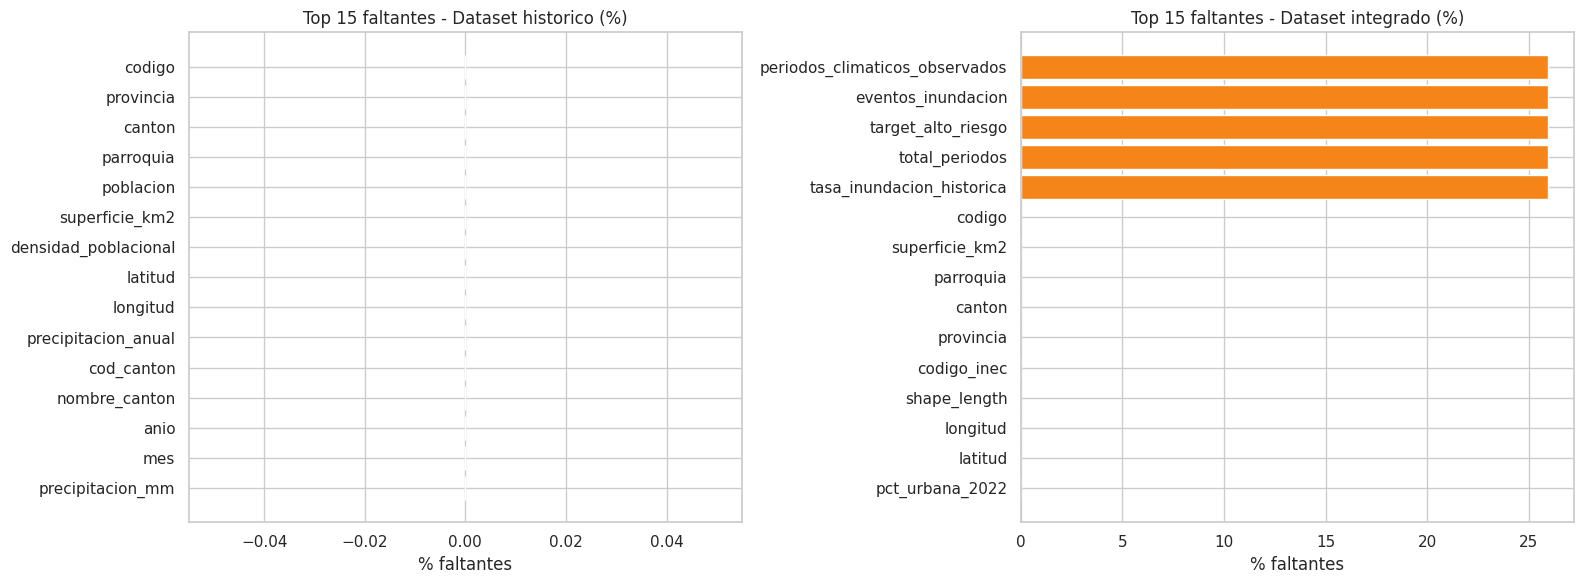

In [12]:
# 7.1 Calidad de datos: porcentaje de faltantes por variable
hist_missing_pct = (df_hist.isna().mean() * 100).sort_values(ascending=False)
full_missing_pct = (df_full.isna().mean() * 100).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(hist_missing_pct.head(15).index[::-1], hist_missing_pct.head(15).values[::-1], color='#4C78A8')
axes[0].set_title('Top 15 faltantes - Dataset historico (%)')
axes[0].set_xlabel('% faltantes')

axes[1].barh(full_missing_pct.head(15).index[::-1], full_missing_pct.head(15).values[::-1], color='#F58518')
axes[1].set_title('Top 15 faltantes - Dataset integrado (%)')
axes[1].set_xlabel('% faltantes')

plt.tight_layout()
plt.show()


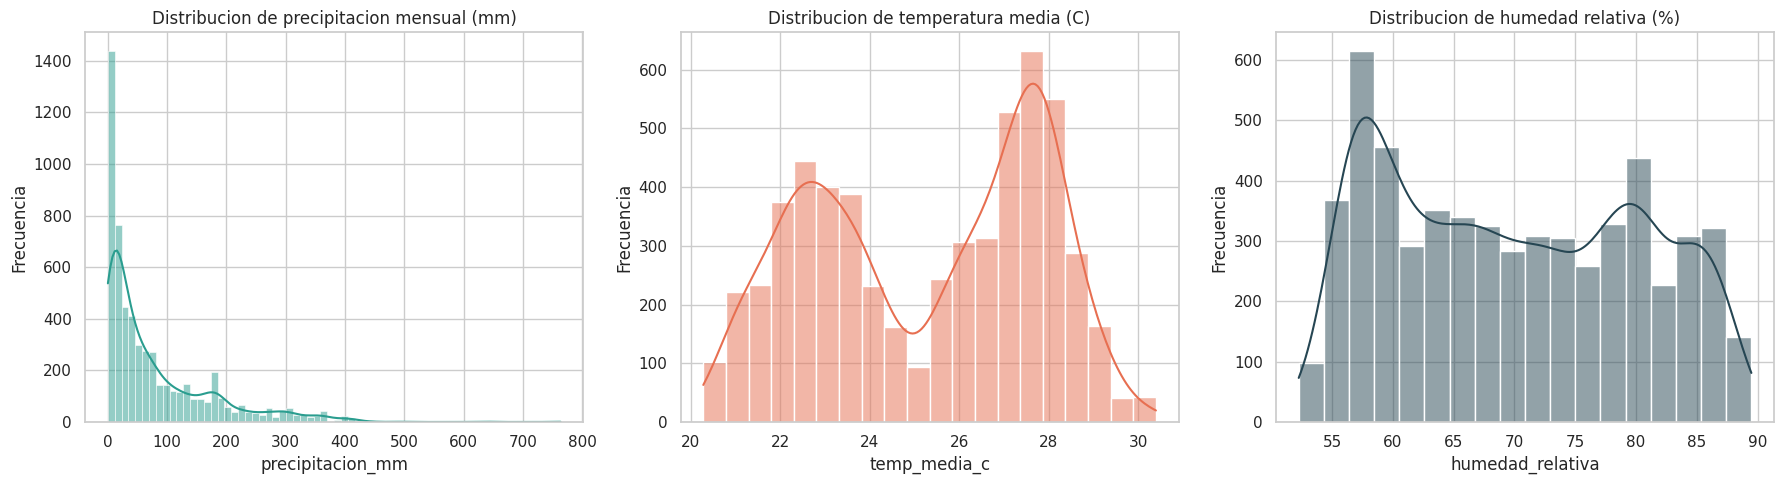

Resumen descriptivo climatico:


,count,mean,std,min,25%,50%,75%,max
precipitacion_mm,5760.0,79.283535,93.991788,0.31,12.00,41.465,116.42,763.22
temp_media_c,5760.0,25.285448,2.568502,20.28,22.89,25.790,27.63,30.40
humedad_relativa,5760.0,69.834299,10.260983,52.26,60.01,69.020,79.12,89.49


In [13]:
# 7.2 Distribuciones climaticas clave
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

if HAS_SNS:
    sns.histplot(df_hist['precipitacion_mm'].dropna(), kde=True, ax=axes[0], color='#2A9D8F')
    sns.histplot(df_hist['temp_media_c'].dropna(), kde=True, ax=axes[1], color='#E76F51')
    sns.histplot(df_hist['humedad_relativa'].dropna(), kde=True, ax=axes[2], color='#264653')
else:
    axes[0].hist(df_hist['precipitacion_mm'].dropna(), bins=30, color='#2A9D8F', alpha=0.8)
    axes[1].hist(df_hist['temp_media_c'].dropna(), bins=30, color='#E76F51', alpha=0.8)
    axes[2].hist(df_hist['humedad_relativa'].dropna(), bins=30, color='#264653', alpha=0.8)

axes[0].set_title('Distribucion de precipitacion mensual (mm)')
axes[1].set_title('Distribucion de temperatura media (C)')
axes[2].set_title('Distribucion de humedad relativa (%)')

for ax in axes:
    ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print('Resumen descriptivo climatico:')
display(df_hist[['precipitacion_mm', 'temp_media_c', 'humedad_relativa']].describe().T)


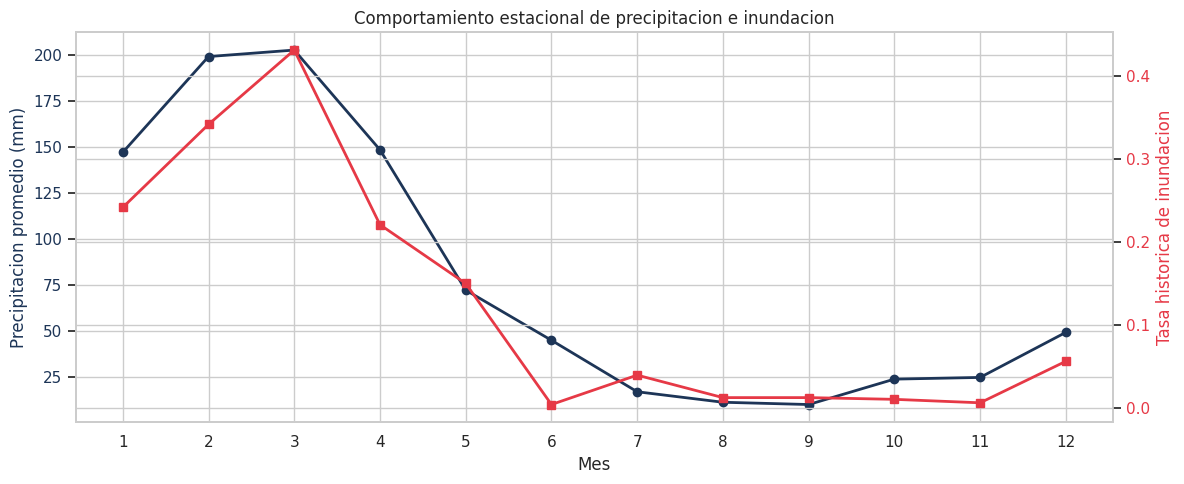

In [14]:
# 7.3 Estacionalidad: precipitacion e inundacion por mes
monthly = (
    df_hist.groupby('mes', as_index=False)
    .agg(
        precipitacion_prom_mm=('precipitacion_mm', 'mean'),
        tasa_inundacion=('inundacion', 'mean')
    )
    .sort_values('mes')
)

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(monthly['mes'], monthly['precipitacion_prom_mm'], marker='o', color='#1D3557', linewidth=2)
ax1.set_xlabel('Mes')
ax1.set_ylabel('Precipitacion promedio (mm)', color='#1D3557')
ax1.tick_params(axis='y', labelcolor='#1D3557')
ax1.set_xticks(range(1, 13))

ax2 = ax1.twinx()
ax2.plot(monthly['mes'], monthly['tasa_inundacion'], marker='s', color='#E63946', linewidth=2)
ax2.set_ylabel('Tasa historica de inundacion', color='#E63946')
ax2.tick_params(axis='y', labelcolor='#E63946')

plt.title('Comportamiento estacional de precipitacion e inundacion')
plt.tight_layout()
plt.show()


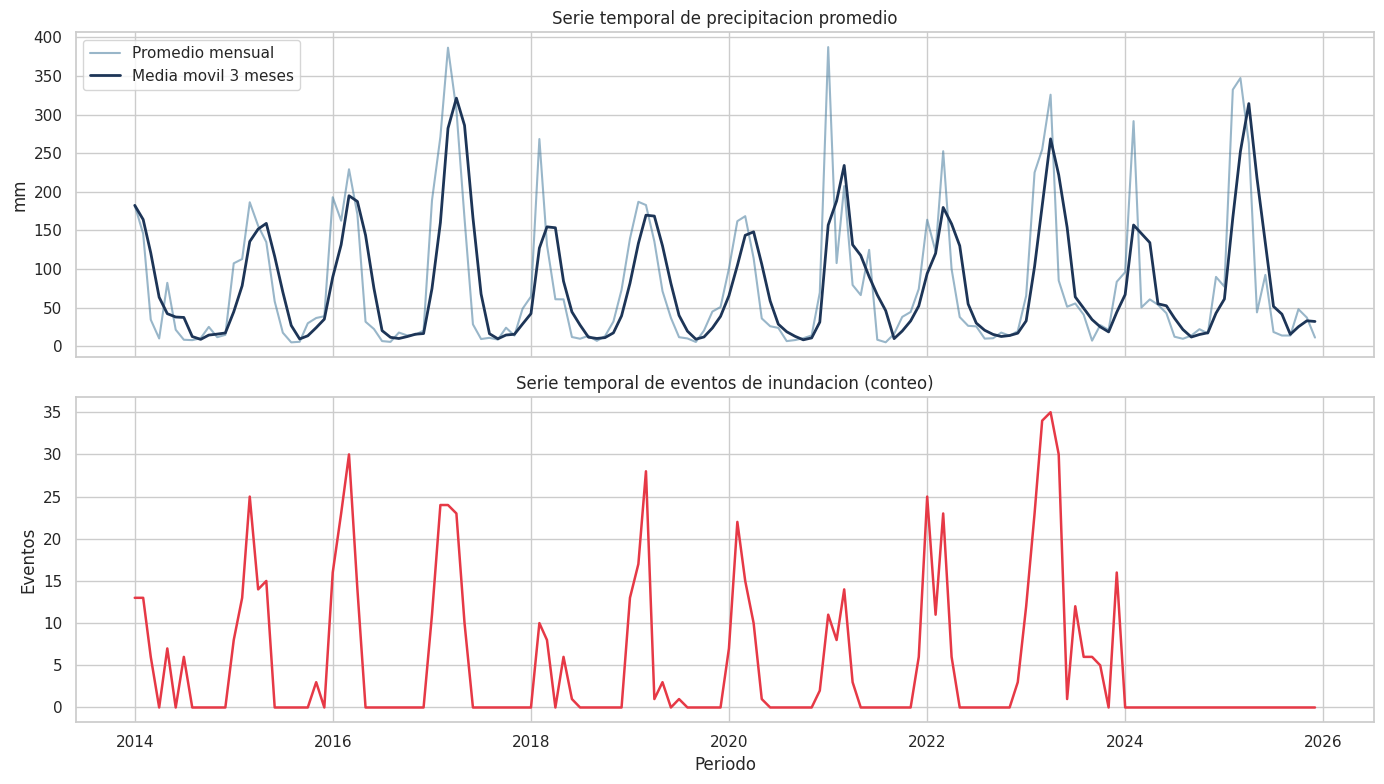

In [15]:
# 7.4 Serie temporal: tendencia de precipitacion y eventos
if 'fecha_periodo' in df_hist.columns:
    ts = (
        df_hist.dropna(subset=['fecha_periodo'])
        .groupby('fecha_periodo', as_index=False)
        .agg(
            precipitacion_prom_mm=('precipitacion_mm', 'mean'),
            eventos_inundacion=('inundacion', 'sum'),
        )
        .sort_values('fecha_periodo')
    )

    ts['precip_mm_ma3'] = ts['precipitacion_prom_mm'].rolling(window=3, min_periods=1).mean()

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    axes[0].plot(ts['fecha_periodo'], ts['precipitacion_prom_mm'], color='#457B9D', alpha=0.55, label='Promedio mensual')
    axes[0].plot(ts['fecha_periodo'], ts['precip_mm_ma3'], color='#1D3557', linewidth=2, label='Media movil 3 meses')
    axes[0].set_title('Serie temporal de precipitacion promedio')
    axes[0].set_ylabel('mm')
    axes[0].legend()

    axes[1].plot(ts['fecha_periodo'], ts['eventos_inundacion'], color='#E63946', linewidth=1.8)
    axes[1].set_title('Serie temporal de eventos de inundacion (conteo)')
    axes[1].set_ylabel('Eventos')
    axes[1].set_xlabel('Periodo')

    plt.tight_layout()
    plt.show()
else:
    print('No existe fecha_periodo para la serie temporal.')


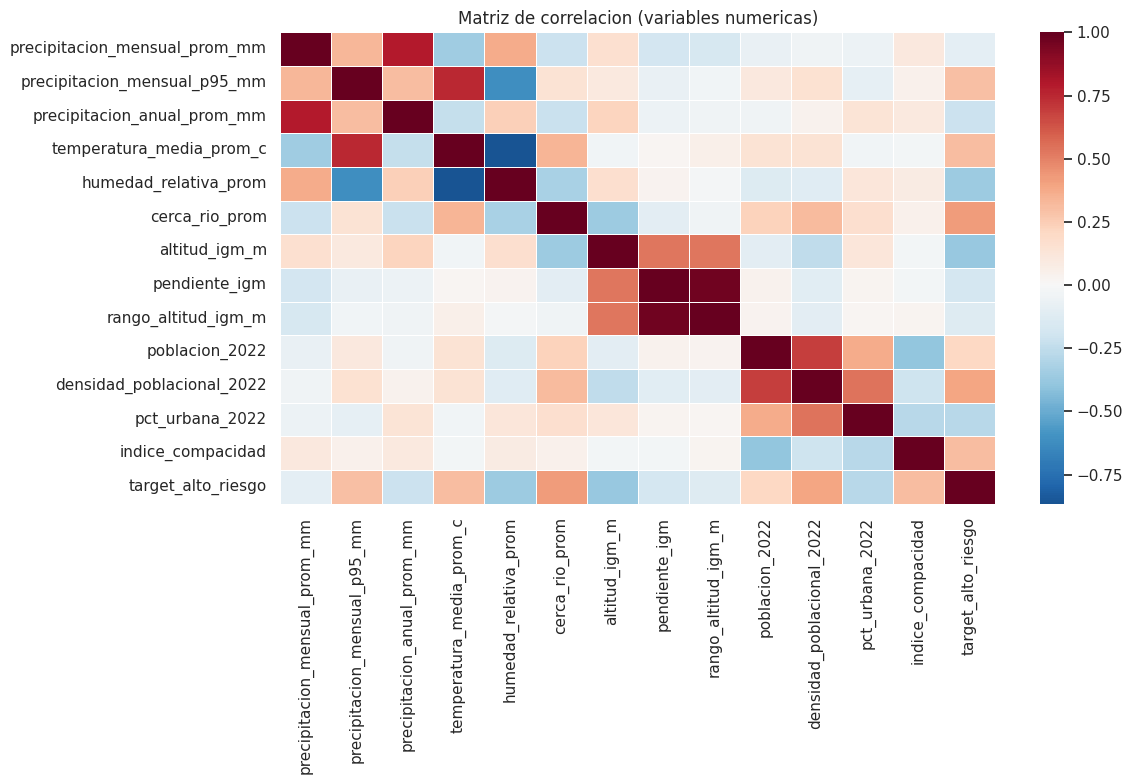

Variables mas asociadas (correlacion absoluta) con target_alto_riesgo:


,correlacion
cerca_rio_prom,0.421637
densidad_poblacional_2022,0.389018
altitud_igm_m,-0.372984
humedad_relativa_prom,-0.355354
temperatura_media_prom_c,0.306744
indice_compacidad,0.305718
precipitacion_mensual_p95_mm,0.299152
pct_urbana_2022,-0.282175
precipitacion_anual_prom_mm,-0.214681
poblacion_2022,0.206673


In [16]:
# 7.5 Correlaciones entre variables numericas y target
corr_base_cols = [
    'precipitacion_mensual_prom_mm', 'precipitacion_mensual_p95_mm', 'precipitacion_anual_prom_mm',
    'temperatura_media_prom_c', 'humedad_relativa_prom', 'cerca_rio_prom',
    'altitud_igm_m', 'pendiente_igm', 'rango_altitud_igm_m',
    'poblacion_2022', 'densidad_poblacional_2022', 'pct_urbana_2022',
    'indice_compacidad', 'target_alto_riesgo'
]

corr_df = df_full[corr_base_cols].copy()
corr_df = corr_df[corr_df['target_alto_riesgo'].notna()].copy()

corr = corr_df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
if HAS_SNS:
    sns.heatmap(corr, cmap='RdBu_r', center=0, annot=False, linewidths=0.5)
else:
    plt.imshow(corr, cmap='RdBu_r', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)

plt.title('Matriz de correlacion (variables numericas)')
plt.tight_layout()
plt.show()

target_corr = corr['target_alto_riesgo'].drop('target_alto_riesgo').sort_values(key=lambda s: np.abs(s), ascending=False)
print('Variables mas asociadas (correlacion absoluta) con target_alto_riesgo:')
display(target_corr.head(10).to_frame('correlacion'))


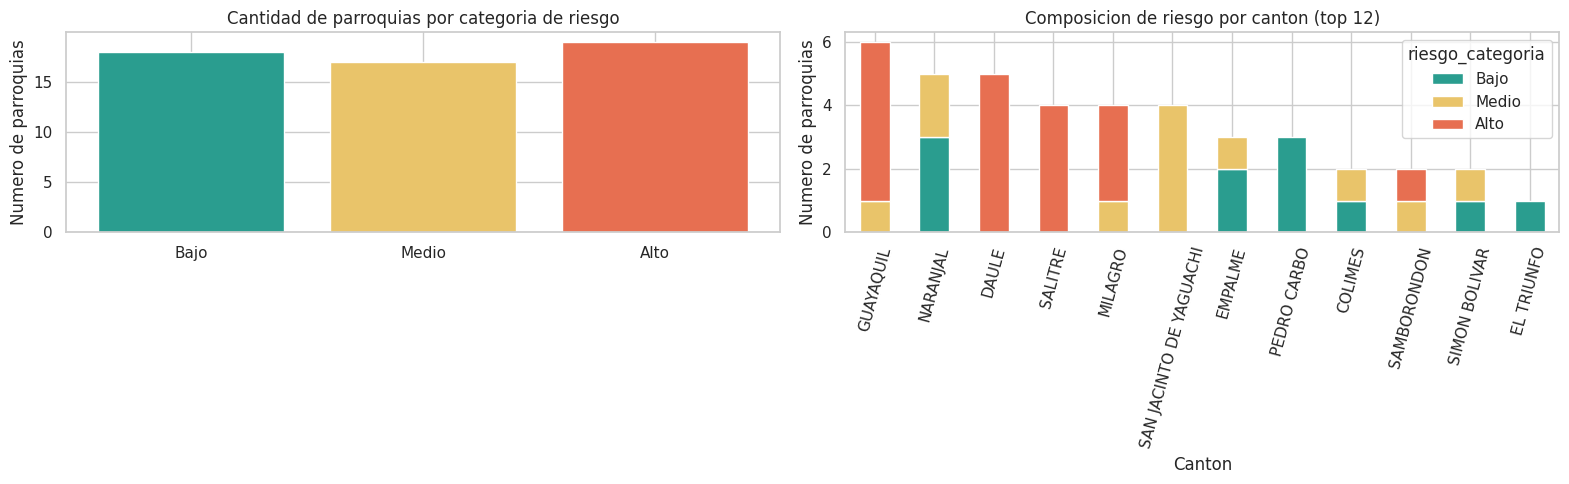

In [17]:
# 7.6 Distribucion de riesgo y analisis por canton
risk_col = 'riesgo_categoria' if 'riesgo_categoria' in df_full.columns else None
if risk_col is None:
    raise ValueError('No existe riesgo_categoria en el dataset integrado.')

risk_order = ['Bajo', 'Medio', 'Alto']
risk_counts = df_full[risk_col].value_counts().reindex(risk_order)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(risk_counts.index, risk_counts.values, color=['#2A9D8F', '#E9C46A', '#E76F51'])
axes[0].set_title('Cantidad de parroquias por categoria de riesgo')
axes[0].set_ylabel('Numero de parroquias')

canton_risk = pd.crosstab(df_full['canton'], df_full[risk_col])
canton_risk = canton_risk.reindex(columns=risk_order, fill_value=0)
top_cantons = canton_risk.sum(axis=1).sort_values(ascending=False).head(12).index
canton_plot = canton_risk.loc[top_cantons]

canton_plot.plot(kind='bar', stacked=True, ax=axes[1], color=['#2A9D8F', '#E9C46A', '#E76F51'])
axes[1].set_title('Composicion de riesgo por canton (top 12)')
axes[1].set_ylabel('Numero de parroquias')
axes[1].set_xlabel('Canton')
axes[1].tick_params(axis='x', rotation=75)

plt.tight_layout()
plt.show()


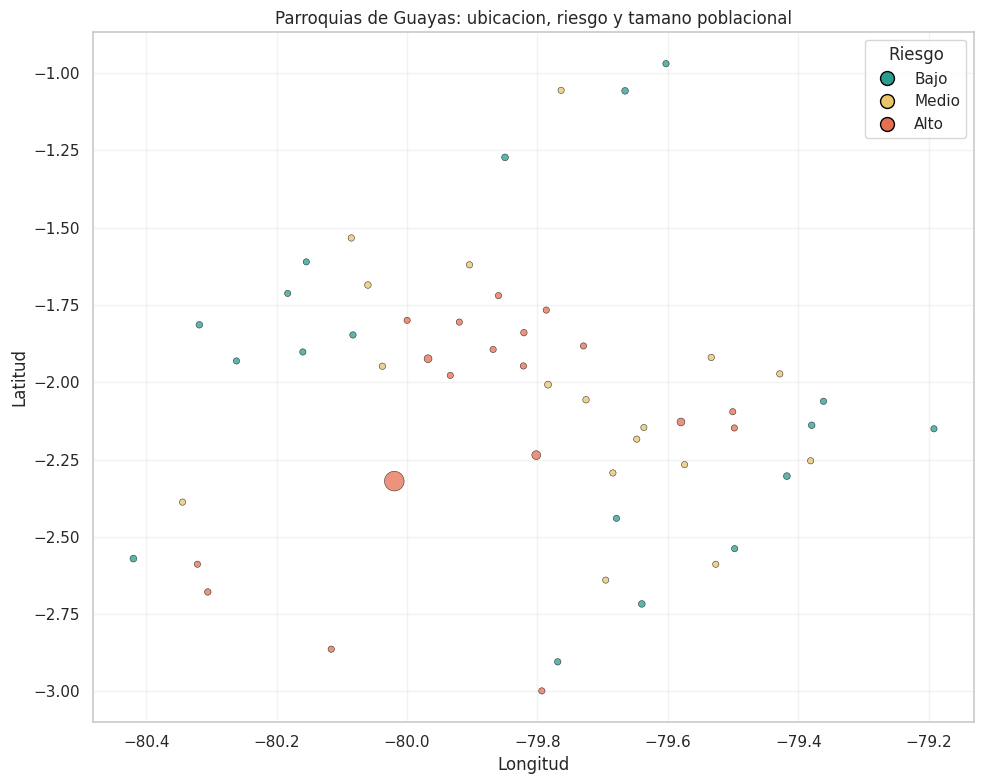

In [18]:
# 7.7 Visualizacion espacial basica (dispersion georreferenciada)
color_map = {'Bajo': '#2A9D8F', 'Medio': '#E9C46A', 'Alto': '#E76F51'}
plot_df = df_full.dropna(subset=['latitud', 'longitud']).copy()
plot_df['color'] = plot_df['riesgo_categoria'].map(color_map).fillna('#6C757D')

size_base = plot_df['poblacion_2022'].fillna(plot_df['poblacion_2022'].median())
size_scaled = 20 + 180 * (size_base - size_base.min()) / (size_base.max() - size_base.min() + 1e-9)

plt.figure(figsize=(10, 8))
plt.scatter(
    plot_df['longitud'],
    plot_df['latitud'],
    c=plot_df['color'],
    s=size_scaled,
    alpha=0.75,
    edgecolors='black',
    linewidths=0.4,
)
plt.title('Parroquias de Guayas: ubicacion, riesgo y tamano poblacional')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=clr, markeredgecolor='black', markersize=10, label=lbl)
    for lbl, clr in color_map.items()
]
plt.legend(handles=legend_handles, title='Riesgo', loc='best')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


### Hallazgos sugeridos para interpretar al ejecutar el notebook

Al correr esta seccion, documenta puntualmente en tu informe:
- Meses con mayor precipitacion promedio y su relacion con la tasa de inundacion.
- Variables con mayor correlacion con `target_alto_riesgo`.
- Cantones con mayor concentracion de parroquias en riesgo medio/alto.
- Patrones espaciales observados en la dispersion georreferenciada.


## 8) Preparacion para modelado y balance de clases

Se entrena solo con parroquias que tienen etiqueta historica (`target_alto_riesgo` no nulo).

Luego se reserva un conjunto de prueba estratificado. Se reporta balance de clases para transparencia metodologica.


In [19]:
feature_cols = [
    'precipitacion_mensual_prom_mm', 'precipitacion_mensual_p95_mm', 'precipitacion_anual_prom_mm',
    'temperatura_media_prom_c', 'humedad_relativa_prom', 'cerca_rio_prom',
    'altitud_igm_m', 'pendiente_igm', 'rango_altitud_igm_m',
    'superficie_km2', 'shape_length', 'latitud', 'longitud',
    'poblacion_2022', 'hogares_2022', 'viviendas_2022',
    'edad_promedio_2022', 'pct_mujeres_2022', 'pct_urbana_2022',
    'densidad_poblacional_2022', 'personas_por_hogar_2022', 'viviendas_por_km2_2022',
    'indice_compacidad'
]

model_df = df_full.copy()

labeled_df = model_df[model_df['target_alto_riesgo'].notna()].copy()
unlabeled_df = model_df[model_df['target_alto_riesgo'].isna()].copy()

y = labeled_df['target_alto_riesgo'].astype(int)
X = labeled_df[feature_cols]

print('Parroquias oficiales Guayas:', len(model_df))
print('Parroquias con historial para entrenamiento:', len(labeled_df))
print('Parroquias sin historial (a predecir):', len(unlabeled_df))
print('Balance de clases (entrenamiento):')
display(y.value_counts().rename({0: 'No alto', 1: 'Alto'}).to_frame('conteo'))
display((y.value_counts(normalize=True) * 100).round(2).rename({0: 'No alto', 1: 'Alto'}).to_frame('porcentaje'))


Parroquias oficiales Guayas: 54
Parroquias con historial para entrenamiento: 40
Parroquias sin historial (a predecir): 14
Balance de clases (entrenamiento):


,conteo
target_alto_riesgo,
No alto,24
Alto,16


,porcentaje
target_alto_riesgo,
No alto,60.0
Alto,40.0


## 9) Modelos requeridos por la rubrica

Se implementan:
1. Regresion Logistica (modelo base).
2. Arbol de Decision.
3. Ensamble (votacion blanda) que combina RL + DT + RF.
4. Optimizacion con GridSearchCV sobre Arbol de Decision (metrica objetivo: recall).


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pre_scaled = ColumnTransformer(
    transformers=[
        (
            'num',
            Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
            ]),
            feature_cols,
        )
    ]
)

pre_unscaled = ColumnTransformer(
    transformers=[
        (
            'num',
            Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
            ]),
            feature_cols,
        )
    ]
)

lr = Pipeline([
    ('preprocess', pre_scaled),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)),
])

dt = Pipeline([
    ('preprocess', pre_unscaled),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced', min_samples_leaf=2)),
])

rf = Pipeline([
    ('preprocess', pre_unscaled),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced_subsample',
        min_samples_leaf=2,
    )),
])

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('dt', dt), ('rf', rf)],
    voting='soft'
)

dt_grid = GridSearchCV(
    estimator=dt,
    param_grid={
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [3, 5, 8, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
    },
    scoring='recall',
    cv=5,
    n_jobs=1,
    refit=True,
)

lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
ensemble.fit(X_train, y_train)
dt_grid.fit(X_train, y_train)
dt_opt = dt_grid.best_estimator_

print('Mejores hiperparametros DT (GridSearchCV):')
print(dt_grid.best_params_)


Mejores hiperparametros DT (GridSearchCV):
{'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}


## 10) Evaluacion comparativa (precision, recall, F1, ROC-AUC)

En gestion de riesgo de inundacion, la metrica prioritaria es **recall** de la clase de alto riesgo,
porque penaliza con mayor severidad los falsos negativos (parroquias realmente riesgosas clasificadas como no riesgosas).


In [21]:
def eval_model(name: str, model, x_test: pd.DataFrame, y_test: pd.Series) -> dict:
    y_pred = model.predict(x_test)
    y_score = model.predict_proba(x_test)[:, 1]
    return {
        'modelo': name,
        'precision': round(precision_score(y_test, y_pred, zero_division=0), 4),
        'recall': round(recall_score(y_test, y_pred, zero_division=0), 4),
        'f1': round(f1_score(y_test, y_pred, zero_division=0), 4),
        'roc_auc': round(roc_auc_score(y_test, y_score), 4),
    }

metrics_table = pd.DataFrame([
    eval_model('Regresion Logistica (Base)', lr, X_test, y_test),
    eval_model('Arbol de Decision', dt, X_test, y_test),
    eval_model('Ensamble RL+DT+RF', ensemble, X_test, y_test),
    eval_model('Arbol de Decision Optimizado (GridSearchCV)', dt_opt, X_test, y_test),
]).sort_values(['recall', 'f1', 'roc_auc'], ascending=False).reset_index(drop=True)

display(metrics_table)

best_model_name = metrics_table.iloc[0, 0]
print('Modelo seleccionado por prioridad recall/f1/auc:', best_model_name)


,modelo,precision,recall,f1,roc_auc
0,Regresion Logistica (Base),0.80,1.00,0.8889,1.0000
1,Ensamble RL+DT+RF,1.00,0.75,0.8571,1.0000
2,Arbol de Decision Optimizado (GridSearchCV),0.75,0.75,0.7500,0.7917
3,Arbol de Decision,1.00,0.50,0.6667,0.7500


Modelo seleccionado por prioridad recall/f1/auc: Regresion Logistica (Base)


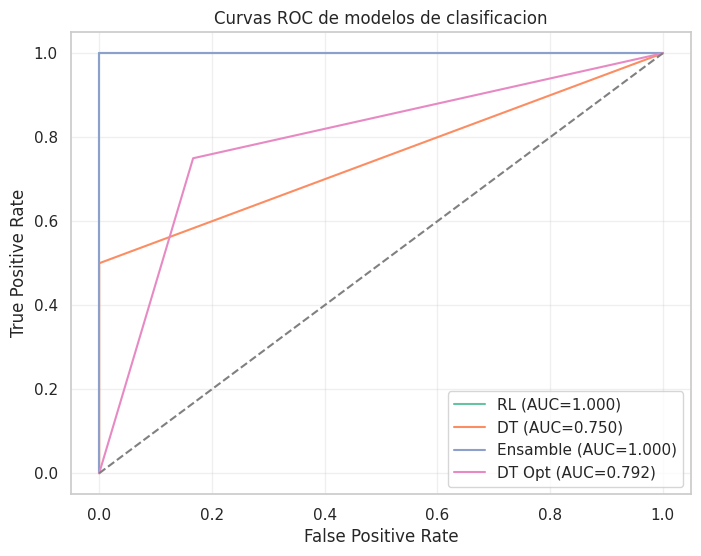

In [22]:
# Curvas ROC comparativas
plt.figure(figsize=(8, 6))

models_for_roc = {
    'RL': lr,
    'DT': dt,
    'Ensamble': ensemble,
    'DT Opt': dt_opt,
}

for label, model in models_for_roc.items():
    scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_value = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f'{label} (AUC={auc_value:.3f})')

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC de modelos de clasificacion')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


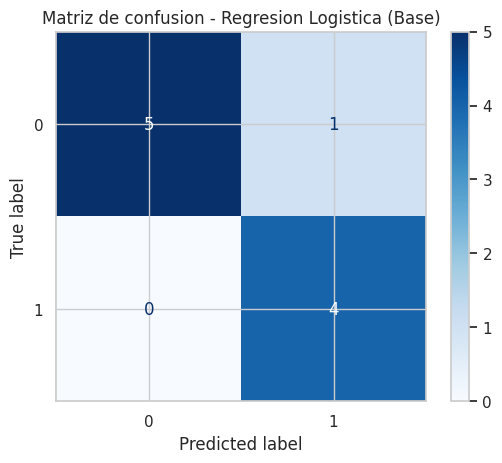

In [23]:
# Matriz de confusion del mejor modelo
best_model = {
    'Regresion Logistica (Base)': lr,
    'Arbol de Decision': dt,
    'Ensamble RL+DT+RF': ensemble,
    'Arbol de Decision Optimizado (GridSearchCV)': dt_opt,
}[best_model_name]

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title(f'Matriz de confusion - {best_model_name}')
plt.show()


## 11) Prediccion final por parroquia y categorias de riesgo

Se aplica el mejor modelo a las 54 parroquias oficiales de Guayas.
La categoria de riesgo final se obtiene por terciles de la probabilidad de inundacion:
- Bajo: probabilidad < P33
- Medio: P33 <= probabilidad < P66
- Alto: probabilidad >= P66


In [24]:
all_probs = best_model.predict_proba(model_df[feature_cols])[:, 1]
model_df['probabilidad_inundacion_calc'] = all_probs

q_low = float(model_df['probabilidad_inundacion_calc'].quantile(0.33))
q_high = float(model_df['probabilidad_inundacion_calc'].quantile(0.66))
if q_low == q_high:
    q_low, q_high = 0.33, 0.66

def risk_label(prob: float) -> str:
    if prob >= q_high:
        return 'Alto'
    if prob >= q_low:
        return 'Medio'
    return 'Bajo'

model_df['riesgo_categoria_calc'] = model_df['probabilidad_inundacion_calc'].apply(risk_label)

print(f'Umbral bajo/medio (P33): {q_low:.4f}')
print(f'Umbral medio/alto (P66): {q_high:.4f}')
print('Distribucion de categorias calculadas:')
print(model_df['riesgo_categoria_calc'].value_counts())


Umbral bajo/medio (P33): 0.1987
Umbral medio/alto (P66): 0.7898
Distribucion de categorias calculadas:
riesgo_categoria_calc
Alto     19
Bajo     18
Medio    17
Name: count, dtype: int64


In [25]:
# Control de cobertura completa y faltantes
coverage_cols = ['codigo', 'parroquia', 'canton', 'provincia', 'probabilidad_inundacion', 'riesgo_categoria']

df_exported_pred = pd.read_csv(predictions_path)
missing_prob = int(df_exported_pred['probabilidad_inundacion'].isna().sum())
missing_risk = int(df_exported_pred['riesgo_categoria'].isna().sum())

print('Predicciones exportadas:', len(df_exported_pred))
print('Parroquias unicas:', df_exported_pred['codigo'].nunique())
print('Sin probabilidad:', missing_prob)
print('Sin categoria de riesgo:', missing_risk)

display(df_exported_pred[coverage_cols].head(10))


Predicciones exportadas: 54
Parroquias unicas: 54
Sin probabilidad: 0
Sin categoria de riesgo: 0


,codigo,parroquia,canton,provincia,probabilidad_inundacion,riesgo_categoria
0,90250,ALFREDO BAQUERIZO MORENO (JUJAN),ALFREDO BAQUERIZO MORENO,GUAYAS,0.757590,Medio
1,90350,BALAO,BALAO,GUAYAS,0.198058,Bajo
2,90450,BALZAR,BALZAR,GUAYAS,0.077504,Bajo
3,90550,COLIMES,COLIMES,GUAYAS,0.276891,Medio
4,90551,SAN JACINTO,COLIMES,GUAYAS,0.179473,Bajo
5,92350,CORONEL MARCELINO MARIDUEÑA (SAN CARLOS),CRNEL. MARCELINO MARIDUEÑA,GUAYAS,0.199362,Medio
6,90650,DAULE,DAULE,GUAYAS,0.875397,Alto
7,90652,JUAN BAUTISTA AGUIRRE (LOS TINTOS),DAULE,GUAYAS,0.945031,Alto
8,90653,LAUREL,DAULE,GUAYAS,0.979404,Alto
9,90654,LIMONAL,DAULE,GUAYAS,0.919458,Alto


## 12) Integracion geoespacial para la aplicacion web (Flask + Leaflet)

Se verifica que el `GeoJSON` consumido por la app contenga propiedades de riesgo y probabilidad por parroquia.
Esto valida el emparejamiento entre geometria y prediccion mediante codigo de parroquia.


In [26]:
with geojson_path.open('r', encoding='utf-8') as f:
    geo = json.load(f)

features = geo.get('features', [])
props_df = pd.DataFrame([ft.get('properties', {}) for ft in features])

required_geo_fields = ['codigo', 'parroquia', 'canton', 'provincia', 'riesgo', 'probabilidad']
missing_geo_fields = [c for c in required_geo_fields if c not in props_df.columns]

print('Features GeoJSON:', len(features))
print('Campos requeridos faltantes en GeoJSON:', missing_geo_fields)
if not missing_geo_fields:
    print('Sin dato de riesgo:', int(props_df['riesgo'].isna().sum()))
    print('Sin dato de probabilidad:', int(props_df['probabilidad'].isna().sum()))

display(props_df[required_geo_fields].head(10))


Features GeoJSON: 54
Campos requeridos faltantes en GeoJSON: []
Sin dato de riesgo: 0
Sin dato de probabilidad: 0


,codigo,parroquia,canton,provincia,riesgo,probabilidad
0,90150,GUAYAQUIL,GUAYAQUIL,GUAYAS,Alto,0.979075
1,90152,JUAN GOMEZ RENDON (PROGRESO),GUAYAQUIL,GUAYAS,Medio,0.663656
2,90153,MORRO,GUAYAQUIL,GUAYAS,Alto,0.887189
3,90156,POSORJA,GUAYAQUIL,GUAYAS,Alto,0.989077
4,90157,PUNA,GUAYAQUIL,GUAYAS,Alto,0.876399
5,90158,TENGUEL,GUAYAQUIL,GUAYAS,Alto,0.981901
6,90250,ALFREDO BAQUERIZO MORENO (JUJAN),ALFREDO BAQUERIZO MORENO,GUAYAS,Medio,0.757590
7,90350,BALAO,BALAO,GUAYAS,Bajo,0.198058
8,90450,BALZAR,BALZAR,GUAYAS,Bajo,0.077504
9,90550,COLIMES,COLIMES,GUAYAS,Medio,0.276891


## 13) Resultados finales y contraste con salida oficial del pipeline

Para evitar divergencias entre notebook y despliegue, se comparan las metricas obtenidas en este cuaderno
contra `outputs/resumen_metricas_modelos.csv` generado por el script oficial del proyecto.


In [27]:
metrics_exported = pd.read_csv(metrics_path)
print('Metricas exportadas por pipeline:')
display(metrics_exported)

print('Metricas recalculadas en notebook:')
display(metrics_table)


Metricas exportadas por pipeline:


,modelo,precision,recall,f1,roc_auc
0,Regresion Logistica (Base),0.80,1.00,0.8889,1.0000
1,Ensamble RL+DT+RF,1.00,0.75,0.8571,1.0000
2,Arbol de Decision Optimizado (GridSearchCV),0.75,0.75,0.7500,0.7917
3,Arbol de Decision,1.00,0.50,0.6667,0.7500


Metricas recalculadas en notebook:


,modelo,precision,recall,f1,roc_auc
0,Regresion Logistica (Base),0.80,1.00,0.8889,1.0000
1,Ensamble RL+DT+RF,1.00,0.75,0.8571,1.0000
2,Arbol de Decision Optimizado (GridSearchCV),0.75,0.75,0.7500,0.7917
3,Arbol de Decision,1.00,0.50,0.6667,0.7500


## 14) Conclusiones tecnicas

1. Se integraron variables climaticas, topograficas y socio-territoriales con trazabilidad de fuente.
2. La variable objetivo fue construida desde eventos historicos, sin usar etiquetas de riesgo predefinidas.
3. Se entrenaron y compararon los modelos requeridos por la rubrica (RL, DT, ensamble, DT optimizado).
4. Recall se uso como criterio prioritario para seleccion del modelo por el contexto de gestion del riesgo.
5. Se verifico cobertura completa de las parroquias oficiales de Guayas en prediccion y GeoJSON.

### Nota metodologica
La robustez del proyecto depende de mantener actualizados los insumos oficiales y reentrenar el pipeline
cuando se incorporen nuevos periodos climaticos o nuevos registros oficiales de eventos adversos.


## 15) Reproducibilidad

Para regenerar artefactos del proyecto desde cero en este repositorio:

```bash
python3 ml/train_and_prepare.py
```

Archivos clave generados:
- `outputs/dataset_guayas_oficial_completo.csv`
- `outputs/predicciones_parroquias.csv`
- `outputs/resumen_metricas_modelos.csv`
- `app/data/parroquias_riesgo.geojson`
- `app/data/predicciones_parroquias.csv`
